<a href="https://colab.research.google.com/github/perfectpanda-works/machine-learning/blob/master/PyTorchTutrial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#分類問題の訓練

##入力データについて

通常、画像、テキストファイル、オーディオファイル、ビデオなどをPythonプログラムで扱うときには、配列としてデータをロードします。これらのデータは、PyTorchのテンソル型に変換することもできます。

イメージを扱うときは、PillowやOpenCV

オーディオを扱うときはscipyやlibrosa

テキストはPythonに組み込まれている関数やCython、NLTKやSpaCy

といったライブラリが役に立ちます。

PyTorchには、画像処理に対しては「torchvision」というパッケージがあります。これは、一般的なデータセット（MNISTやCIFAR１０など）のローダーを備えていたり、「torchvision.datasets」や「torch.utils.data.DataLoader」といった機能でより便利になっています。

チュートリアルでは、「CIFAR10」といデータセットを利用します。このデータセットは10クラス問題のための画像データを提供してくれます。
答えのクラスとして
‘airplane’,
‘automobile’,
‘bird’
‘cat’
‘deer’
‘dog’
‘frog’
‘horse’
‘ship’
‘truck’
に画像を分類します。
画像サイズは3×32×32です。RGBの3チャンネル画像なので３次元の配列形式です。

#画像分類器の訓練

チュートリアルの全体像は次のような感じです。

1.CIFAR10データの読み込みとNormalize

torchvisionを利用してCIFAR10の訓練データとテストデータを読み込み、データを正規化します。

2.畳み込みニューラルネットワークを定義

3.損失関数を定義

4.訓練データでネットワークを訓練

5.テストデータで評価

##1.CIFAR10データの読み込みとNormalize

※標準化、正規化など日本語だとややこしい感じがするので、Normalizeとしています。-1~1の範囲にデータをスケーリングするような処理です。以前、scikit-klearnで勉強した標準化、standardizationとは違う処理です。

CIFAR10のデータは、torchvisionを利用するとめちゃくちゃ楽にロードできる、らしいです。

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvisionからロードするデータは、「0から１」の範囲の値のデータとなっています。テンソル型のデータとして読み込む際に、Normalize、「-1から1」の範囲にNormalize、も同時に行います。

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transformという変換するためのライブラリからComposeを呼び出すことで、いくつかの画像処理をまとめて行うことができます。一つ目は、テンソルに変換「ToTensor」、二つ目が「Normalize」の処理です。
Normalizeは、引数に（平均,標準偏差）を与えるのですが、今回RGBの3チャンネルの画像のため、平均が(0.5,0.5,0.5)のようにチャンネル分指定してあります。また、標準偏差も同様に(0.5,0.5,0.5)としてあります。この辺りのNormalizetionについてはもう少し別で調べる必要がありそうですが、今回は0から1のデータを-1から1にスケーリングする用途ということで、このパラメータを定型化できそうなので、ここまでにしておきます。

PyTorchのドキュメント

https://pytorch.org/docs/stable/torchvision/transforms.html

まずはCIFAR１０の訓練データセットをダウンロードして、Normalizeなど変換処理をおこなったものをtrainsetに格納です。
そして、ついでにバッチ単位にデータを分割しておきます。

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


テストデータも同様に読み込んでおきます。

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


答えクラスのラベルを次のようにして格納しておきます。

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ダウンロードしたCIFAR10データセットのいくつかを表示して確認します。
画像の表示には、matplotlibを利用します。

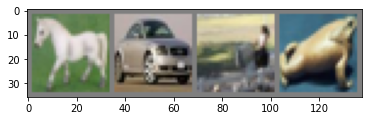

horse   car horse  frog


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

まずは、imshow関数の定義です。

imgのデータはNormalizeされているデータを受け取る予定です。
受け取ったデータを、0から1の範囲のデータに戻しています。そして、numpyのデータとして（ndarray型）npimgに格納します。

matplotlibのimshowは、引数として最後にチャンネル数を取るため、numpyのtransposeにて「32×32×3」という順番の多次元配列に変換しています。
最後にshowで画像表示です。

次に、Pythonのiter()「イテレータ」でtrainloaderのバッチを一つ読み込んでいます。１つのバッチには４枚の画像がありますので、nextでたどると４枚の画像とラベルが取り出せるようになってるようです。

CIFAR10のデータの数を確認しておきます。

In [ ]:
print("訓練データの数")
print(len(trainset))
print("テストデータの数")
print(len(testset))

訓練データの数
50000
テストデータの数
10000


##2.畳み込みニューラルネットワークを定義

以前チュートリアルで定義したものよりシンプルになっています。

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #畳み込み層1の入力画像を3チャンネルに
        self.conv1 = nn.Conv2d(3, 6, 5)
        #プーリング層として定義する
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #このように畳み込み層とプーリング層を表現することもできる
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #全結合ニューラルネットワークに入力するためにデータをベクトル化
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

「Conv1」畳み込み層１の入力を以前は１チャンネルとしていたところを3チャンネルと変更します。今回は1画像に対してRGBの3チャンネルの情報が存在します。

「pool」としてプーリング層を定義しています。
以前は、max_pool2dメソッドを利用してforwardメソッド内でプーリングを実行していましたが、プーリング層として定義に入れることもできるようです。今回は2×2のフィルタをもつプーリング層を定義しています。

また、全結合ニューラルネットワークへ入れるデータは横並びデータ（ベクトル）になっていないといけないので、これをviewメソッドを利用して行っています。

畳み込みニューラルネットワークの層の構成自体は同じですが、前回のチュートリアルよりシンプルな書き方となっています。

##3.損失関数を定義

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

損失関数を「クロスエントロピー誤差関数」に設定します。

クロスエントロピー誤差関数は、過去にも多クラス分類のときによく利用する誤差関数、程度でしか紹介はしていませんが、今回もそのノリで進めさせていただきます。


そして、最適化手法を「確率的勾配降下法(SGD)」と設定します。SGDには学習率というハイパーパラメータを与えないといけませんので、lr=0.001として学習率を設定しています。SGDには、MomentumSGDという進化したものがあります。過去の更新した勾配も少しだけ影響させて重みの更新をおこなう、ようなイメージのSGDです。（だと思います、まだ詳しくは調査します。）その過去の勾配の影響具合をmomentumという係数で指定ている模様です。momentumを0にすると普通のSGDになります。

##4.訓練データでネットワークを訓練

In [ ]:
for epoch in range(2):  #チュートリアルでは2エポック訓練を行う。

    running_loss = 0.0
    #enumerateでiにリスト番号、dataに内容が入る。
    for i, data in enumerate(trainloader, 0):
        #data変数は[inputs, labels]のリストデータ。
        inputs, labels = data

        #勾配のパラメータを初期化
        optimizer.zero_grad()

        #順伝播し、逆伝播して重みを更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    #ミニバッチ2000ごとに状況の表示
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.919
[1,  6000] loss: 1.706
[1,  8000] loss: 1.608
[1, 10000] loss: 1.552
[1, 12000] loss: 1.496
[2,  2000] loss: 1.413
[2,  4000] loss: 1.384
[2,  6000] loss: 1.380
[2,  8000] loss: 1.332
[2, 10000] loss: 1.321
[2, 12000] loss: 1.297
Finished Training


最初の大枠のforループは、エポックのループです。ニューラルネットワークは１エポックで１回全データを使用することになります。内側のforループにてバッチ単位で重みを更新していく処理になります。trainloaderにはバッチ分割されたデータがはいっているので、これを読みだしてループを行います。

enumerate()はリストの添え字とデータを同時に取ってきます。第二引数は始まるインデックスNoを指定しますが、今回は0なのでtrainloaderの0番目のデータから取得してきます。

running_lossには、2000ミニバッチ分の正解との誤差が累積されていきます。累積された誤差は、2000回のミニバッチの訓練が完了した際に、2000で割ることで2000回のミニバッチ訓練を１セットとした平均的な誤差が出力されます。2000のミニバッチ毎にこれを行うことで、誤差が小さくなってきているのかを確認するために利用しています。

.item()メソッドは、テンソル型から一つだけ値を取り出すときに利用するのでした。このような利用方法もあるのですね。

もちろん、2000回のミニバッチ完了毎に0にリセットします。

###訓練モデルの保存
PyTorchでは、次のように訓練モデルを保存できます。

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

##テストデータで評価

テストデータの表示をしてみます。

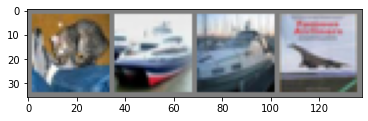

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

###訓練モデルのロード

保存したニューラルネットワークの訓練モデルを読み込みます。
loadメソッドの引数「Path」は先に指定したディレクトリです。

ニューラルネットワークの訓練済みパラメータを呼び出すイメージです。

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

###予測

In [ ]:
outputs = net(images)
print(outputs)

tensor([[-2.2456, -3.0535,  0.9128,  2.4592,  2.1587,  2.1558,  2.8599,  0.5596,
         -2.9859, -2.6490],
        [-2.6678, -3.3542,  1.4564,  3.3314, -0.7947,  5.2420, -0.3214,  2.1732,
         -2.1843, -2.5228],
        [ 2.5839, -1.2858,  2.6275, -0.7872,  4.8332, -0.4881, -1.2820, -0.2292,
         -1.9573, -3.4837],
        [-0.0959, -3.2768,  1.0982, -0.0127,  4.6545,  0.6341, -1.4771,  6.0890,
         -4.3654, -1.5090]], grad_fn=<AddmmBackward>)


1枚の画像に対して、10の出力が出てきています。それが1バッチ4枚分の答えがありますので、outputsは4×10の行列になっています。

ニューラルネットの答えとしては、行の中でもっとも数値の大きな値のものが予測の回答となりますので、次のようにmaxメソッドで一番大きな値を取り出してあげる必要があります。maxの第二引数の「1」は、行方向に対して最大値を取り出すように指定している１です。0にすると縦方向になってしまうので、今回は1と指定します。

In [ ]:
_, predicted = torch.max(outputs, 1)

print(predicted)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

tensor([3, 8, 0, 0])
Predicted:    cat  ship plane plane


maxメソッドを通すことで、predictedに4枚の画像のクラスが並んでいます。

テストデータ全体としてどれくらいの精度が出るかを見てみます。

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


#GPUに処理をさせる

GPUは本来グラフィックの重い処理をCPUに負担をかけず高速に演算できるように利用されていたコンピュータの構成要素になります。最近では、GPUをより汎用的な演算に利用することができるようになってきています。C言語やPythonなどのプログラミング言語からもGPUが気軽に利用できるような仕組み、プラットフォームがNVIDIAのCUDAになります。

PyTorchには、CUDAを利用して計算を分散させて、処理を行うことができます。。

Macではどうやら結構前にCUDAが排除されているみたいです・・・ということは、本格的にニューラルネットワークを訓練してGPUを拡張する場合は、WindowsやLinuxマシンが良いということでしょうか。PythonなのでどのOSでも良いと思いますが。

また、GoogleColaboratoryでは設定を変更することでGPUでの計算が利用でき、CUDAを試すこともできます。

Google colaboでGPUを利用するためには、「ランタイム」→「ランタイムのタイプの変更」メニューで、GPUを選択する必要があります。

次のようにして、利用できるGPUデバイスを確認して、存在していれば「device」として利用できるようにします。

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


作成したニューラルネットワークは、次のようにデバイスを指定してGPUで処理を行うようにできます。

In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
for epoch in range(2):#エポック

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):#ミニバッチ
        #ここの行をGPU用に変更する必要がある。
        inputs, labels = data[0].to(device), data[1].to(device)

        #勾配のパラメータを初期化
        optimizer.zero_grad()

        #順伝播し、逆伝播して重みを更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    #ミニバッチ2000ごとに状況の表示
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
print('Finished Training')

[1,  2000] loss: 1.235
[1,  4000] loss: 1.259
[1,  6000] loss: 1.224
[1,  8000] loss: 1.262
[1, 10000] loss: 1.235
[1, 12000] loss: 1.250
[2,  2000] loss: 1.248
[2,  4000] loss: 1.238
[2,  6000] loss: 1.249
[2,  8000] loss: 1.247
[2, 10000] loss: 1.258
[2, 12000] loss: 1.226
Finished Training
